# Importing Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, pmap, random, lax, value_and_grad, tree_map, devices

from tqdm import trange
import pickle
import os.path as pt

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

In [3]:
attemptno = 1
n = 139999
loadpath = pt.abspath(pt.join(pt.abspath(''), '..', 'Data/Hyperparameters/LinearSum/' + str(n) + '_' + str(attemptno) + 'xvel' + '.pkl'))

In [4]:
with open(loadpath, 'rb') as f:
    xdict = pickle.load(f)

In [5]:
sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag = xdict["Parameters"]
elbo_history = xdict["ELBO History"]
trainind = xdict["Training Sets"]
isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag = xdict["Initial Parameters"]
num_f, num_b, num_ind, num_filt, num_tbin, num_mach = xdict["Training Parameters"]
f_maxt, time_bin = xdict["Filter Form"]

# Prior Functions

In [6]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [7]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

# Obtaining Training Data

## Importing Spike Trains and Finger Movement

In [8]:
datapath = pt.abspath(pt.join(pt.abspath(''), '..', 'Data/Allfinger_veldata.h5'))
alldata = pd.read_hdf(datapath) # Import DataFrame

In [9]:
data = [alldata.loc[i] for i in trainind]

In [10]:
subsamp = int(time_bin/0.001)
spikedat = [data[i].spikes.to_numpy()[:num_tbin, :num_filt].T[:,::subsamp, None] for i in trainind]

In [11]:
ytime = [(data[i].index / np.timedelta64(1, 's')).to_numpy()[:num_tbin:subsamp] for i in trainind] # Get spikes/output time array

In [12]:
# Get x velocities
xraw = [data[i].finger_vel.x.to_numpy()[:num_tbin:subsamp].reshape(n + 1, 1) for i in trainind]

## Standardising Data

In [13]:
# Set variance to 1.0
xvel = [xraw[i] / np.std(xraw[i]) for i in trainind]

In [14]:
k = np.floor(f_maxt/time_bin).astype(np.int16) # Maximum index of filter data

ftime = np.linspace(0.0, f_maxt, k + 1).reshape((k + 1, 1)) # Filter corresponding time array

In [15]:
batch_size = num_filt // num_mach
# FFT of spike train
spikepad = [np.hstack((spikedat[i], np.zeros((num_filt, k, 1)))) for i in trainind]
spikefft = [np.fft.rfft(spikepad[i], axis=1) for i in trainind]
fftlen = [np.shape(spikefft[i])[1] for i in trainind]
spikefft = [spikefft[i].reshape(num_mach, batch_size, fftlen[i], 1) for i in trainind]
spikefft = [[spikefft[j][i] for j in range(len(trainind))] for i in range(num_mach)]
spikefft = jnp.asarray(spikefft)
xvel = jnp.asarray(xvel)

In [16]:
num_train = len(trainind)
spikeffta = [np.asarray([spikefft[i][j] for i in range(num_mach)]) for j in range(num_train)]
spikefftf = [spikeffta[i].reshape(num_filt, fftlen[i], 1) for i in range(num_train)]

In [17]:
Diag = vmap(jnp.diag)

In [18]:
PDiag = pmap(Diag)

In [19]:
@jit
def Set(Matrix, Indices, NewVals):
  return Matrix.at[:, Indices[0], Indices[1]].set(NewVals)

In [20]:
PSet = pmap(Set, in_axes=(0, None, 0,))

In [21]:
@jit
def LowerSolv(MatA, MatB):
  return jsc.linalg.solve_triangular(MatA, MatB, lower = True)

In [22]:
VLS = vmap(LowerSolv)

In [23]:
@partial(jit, static_argnums = (1, 2, 3,))
def OUTconvolve(Filters, Num_Filt, K, N, Spike_FFT):
  Pad = jnp.hstack((Filters, jnp.zeros((Num_Filt, N, 1))))
  Pred_fft = jnp.fft.rfft(Pad, axis = -2)
  Pred_sum = jnp.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = jnp.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

# X Velocity

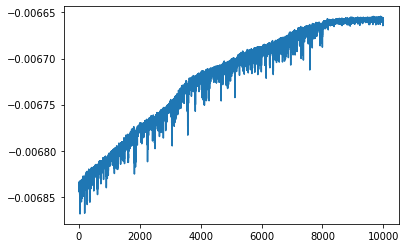

In [24]:
plt.plot(elbo_history[10000:])

In [25]:
indices = jnp.asarray(jnp.tril_indices(num_ind, -1))

In [26]:
ilag = ilag ** 2

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag) + ilag

idz = PDiag(np.exp(il_diag))
print(il_diag.shape)
print(idz.shape)
il_matrix = PSet(idz, indices, il_odiag)


lag = lag ** 2

z_vector = (0.5 * np.sin( np.pi * (z_fracs - 0.5)) + 0.5) * (ftime[-1] - lag) + lag

d = PDiag(np.exp(l_diag))
l_matrix = PSet(d, indices, l_odiag)
print(d.shape)
print(l_matrix.shape)

(8, 16, 20)
(8, 16, 20, 20)
(8, 16, 20, 20)
(8, 16, 20, 20)


In [27]:
isigma_ff = isigma_f.reshape(num_filt, 1)
iellf = iell.reshape(num_filt, 1)
iz_vectorf = iz_vector.reshape(num_filt, num_ind, 1)
iv_vectorf = iv_vector.reshape(num_filt, num_ind, 1)
il_matrixf = il_matrix.reshape(num_filt, num_ind, num_ind)
itrisef = itrise.reshape(num_filt, 1)
itaudifff = itaudiff.reshape(num_filt, 1)
ilagf = ilag.reshape(num_filt, 1)

sigma_ff = sigma_f.reshape(num_filt, 1)
ellf = ell.reshape(num_filt, 1)
z_vectorf = z_vector.reshape(num_filt, num_ind, 1)
v_vectorf = v_vector.reshape(num_filt, num_ind, 1)
l_matrixf = l_matrix.reshape(num_filt, num_ind, num_ind)
trisef = trise.reshape(num_filt, 1)
taudifff = taudiff.reshape(num_filt, 1)
lagf = lag.reshape(num_filt, 1)

## Variational Predictions

In [28]:
fpred_points = ftime.copy()

In [36]:
scisigmaf = isigma_ff[:, None]
sciellf = iellf[:, None]
scitrisef = itrisef[:, None]
scitaudifff = itaudifff[:, None]
scilagf = ilagf[:, None]

ikmm = Squared_exp(iz_vectorf, iz_vectorf.transpose(0, 2, 1), scisigmaf, sciellf)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vectorf, fpred_points.T, scisigmaf, sciellf)
ibzast = VLS(icpred, ikzast)
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, scitrisef, scitaudifff, scilagf)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vectorf)

ikastast = Squared_exp(fpred_points, fpred_points.T, scisigmaf, sciellf)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrixf @ il_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

2022-05-30 10:36:25.525032: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2141] Execution of replica 0 failed: INTERNAL: CustomCall failed: jaxlib/cublas_kernels.cc:44: operation cublasCreate(&handle) failed: cuBlas has not been initialized


XlaRuntimeError: INTERNAL: CustomCall failed: jaxlib/cublas_kernels.cc:44: operation cublasCreate(&handle) failed: cuBlas has not been initialized

: 

In [29]:
scfsigmaf = sigma_ff[:, None]
scfellf = ellf[:, None]
scftrisef = trisef[:, None]
scftaudifff = taudifff[:, None]
scflagf = lagf[:, None]

kmm = Squared_exp(z_vectorf, z_vectorf.transpose(0, 2, 1), scfsigmaf, scfellf)
cpred = np.linalg.cholesky(kmm + 1e-6 * np.eye(num_ind))
kzast = Squared_exp(z_vectorf, fpred_points.T, scfsigmaf, scfellf)
bzast = VLS(cpred, kzast)
bzastT = bzast.transpose(0, 2, 1)
predenv = AlpEnvelope(fpred_points, scftrisef, scftaudifff, scflagf)
predenvT = predenv.transpose(0, 2, 1)
meanpred = predenv * (bzastT @ v_vectorf)

kastast = Squared_exp(fpred_points, fpred_points.T, scfsigmaf, scfellf)
covpred = predenv * (kastast + bzastT @ (l_matrixf @ l_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ bzast) * predenvT

In [31]:
index = 2

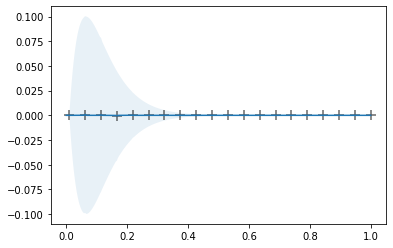

In [ ]:
ipredindenv = AlpEnvelope(iz_vectorf, scitrisef, scitaudifff, scilagf)

plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vectorf[index], (ipredindenv * (icpred @ iv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)

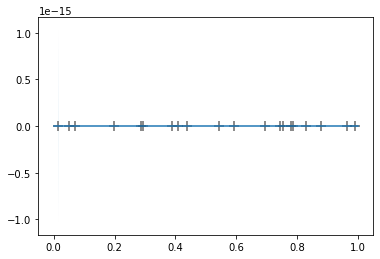

In [32]:
predindenv = AlpEnvelope(z_vectorf, scftrisef, scftaudifff, scflagf)

plt.plot(fpred_points, meanpred[index])
xs2 = np.sqrt(np.diag(covpred[index]))
fill = (meanpred[index].flatten() - xs2, meanpred[index].flatten() + xs2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(z_vectorf[index], (predindenv * (cpred @ v_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)

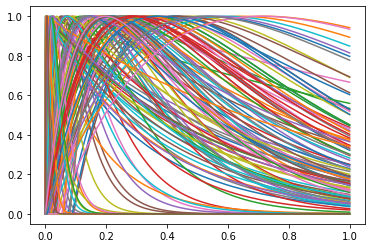

In [33]:
envelopes = AlpEnvelope(ftime, scftrisef, scftaudifff, scflagf)
for i in envelopes:
  plt.plot(ftime, i)

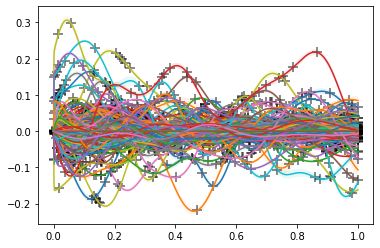

In [34]:
for inds in range(num_filt):
  plt.plot(fpred_points, meanpred[inds])
  s2 = np.sqrt(np.diag(covpred[inds]))
  fill = (meanpred[inds].flatten() - s2, meanpred[inds].flatten() + s2)
  plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
  plt.scatter(z_vectorf[inds], (predindenv * (cpred @ v_vectorf))[inds], s = 100, marker = '+', c='k', alpha = 0.6)

In [35]:
@partial(jit, static_argnums = (1, 2, 3,))
def OUTconvolve(Filters, Num_Filt, K, N, Spike_FFT):
  Pad = jnp.hstack((Filters, jnp.zeros((Num_Filt, N, 1))))
  Pred_fft = jnp.fft.rfft(Pad, axis = -2)
  Pred_sum = jnp.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = jnp.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

In [36]:
plotting = 0

In [ ]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

imeanpredict = OUTconvolve(imeanpred, num_filt, k, n, spikefftf[plotting])
imeanpredictns2 = OUTconvolve(imeanpred - is2, num_filt, k, n, spikefftf[plotting])
imeanpredictps2 = OUTconvolve(imeanpred + is2, num_filt, k, n, spikefftf[plotting])

In [37]:
s2 = np.sqrt(np.diagonal(covpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

meanpredict = OUTconvolve(meanpred, num_filt, k, n, spikefftf[plotting])
meanpredictns2 = OUTconvolve(meanpred - s2, num_filt, k, n, spikefftf[plotting])
meanpredictps2 = OUTconvolve(meanpred + s2, num_filt, k, n, spikefftf[plotting])

In [ ]:
plt.plot(ytime[plotting], imeanpredict)
plt.plot(ytime[plotting], xvel[plotting])
plt.fill_between(ytime[plotting].flatten(), imeanpredictns2.flatten() - isigma_n,  
                  imeanpredictps2.flatten() + isigma_n, alpha = 0.5)

NameError: name 'imeanpredict' is not defined

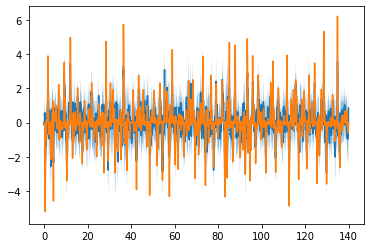

In [38]:
plt.plot(ytime[plotting], meanpredict)
plt.plot(ytime[plotting], xvel[plotting])
plt.fill_between(ytime[plotting].flatten(), meanpredictns2.flatten() - sigma_n,  
                  meanpredictps2.flatten() + sigma_n, alpha = 0.5)

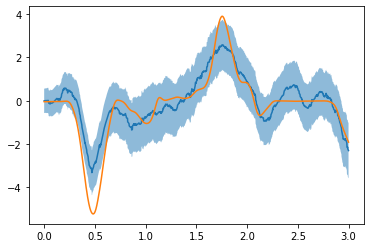

In [39]:
xsnip = xvel[:, :3000]
timesnip = ytime[0][:3000]
meansnip = meanpredict[:3000]
meansnipns2 = meanpredictns2[:3000]
meansnipps2 = meanpredictps2[:3000]
plt.plot(timesnip, meansnip)
plt.plot(timesnip, xsnip[0])
plt.fill_between(timesnip.flatten(), meansnipns2.flatten() - sigma_n,  
                  meansnipps2.flatten() + sigma_n, alpha = 0.5)

# On Test Data

In [40]:
testind = (3,)
num_test = len(testind)

In [41]:
testdat = [alldata.loc[i] for i in testind]

In [42]:
tes_bins = 161393
ntest = tes_bins - 1

In [43]:
testspike = [testdat[i].spikes.to_numpy()[:tes_bins, :num_filt].T[:,::subsamp, None] for i in range(num_test)]

In [44]:
testpad = [jnp.hstack((i, jnp.zeros((num_filt, k, 1)))) for i in testspike]
testspikefft = jnp.asarray([np.fft.rfft(i, axis = -2) for i in testpad])

In [45]:
testtime = [(testdat[i].index / np.timedelta64(1, 's')).to_numpy()[:tes_bins:subsamp] for i in range(num_test)]

In [46]:
# Get x velocities
xrawtes = [testdat[i].finger_vel.x.to_numpy()[:tes_bins:subsamp].reshape(ntest + 1, 1) for i in range(num_test)]

## Standardising Data

In [47]:
# Set variance to 1.0
xtest = np.asarray([xrawtes[i] / np.std(xrawtes[i]) for i in range(num_test)])

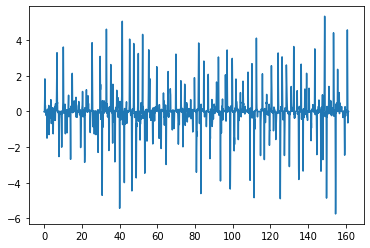

In [48]:
for i in range(num_test):
  plt.plot(testtime[i], xtest[i])

## Plotting vs Test

In [49]:
tplotting = 0

In [50]:
tmeanpredict = OUTconvolve(meanpred, num_filt, k, ntest, testspikefft[tplotting])
tmeanpredictns2 = OUTconvolve(meanpred - s2, num_filt, k, ntest, testspikefft[tplotting])
tmeanpredictps2 = OUTconvolve(meanpred + s2, num_filt, k, ntest, testspikefft[tplotting])

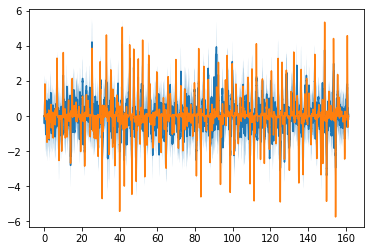

In [51]:
plt.plot(testtime[tplotting], tmeanpredict)
plt.plot(testtime[tplotting], xtest[tplotting])
plt.fill_between(testtime[tplotting].flatten(), tmeanpredictns2.flatten() - sigma_n,  
                  tmeanpredictps2.flatten() + sigma_n, alpha = 0.5)

## R^2

## X Velocity

### Test Data

In [52]:
rtplotting = 0

In [53]:
alltestpredict = np.asarray([OUTconvolve(meanpred, num_filt, k, ntest, i) for i in testspikefft])

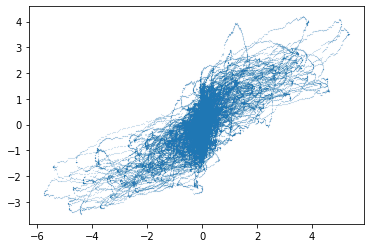

In [54]:
plt.scatter(xtest[rtplotting], alltestpredict[rtplotting], s=.005)

In [55]:
tess = np.sum(np.asarray([np.square(xtest[i] - alltestpredict[i]) for i in range(num_test)]))
ttss = np.sum(np.asarray([np.square(xtest[i] - np.mean(xtest[i])) for i in range(num_test)]))
tr2 = 1 - tess/ttss
print(tr2)

0.5173322681953473


### Training Data

In [56]:
rplotting = 0

In [57]:
allpredict = np.asarray([OUTconvolve(meanpred, num_filt, k, n, i) for i in spikefftf])

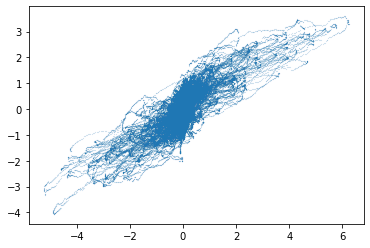

In [58]:
plt.scatter(xvel[rplotting], allpredict[rplotting], s=.005)

In [59]:
ess = np.sum(np.asarray([np.square(xvel[i] - allpredict[i]) for i in range(num_train)]))
tss = np.sum(np.asarray([np.square(xvel[i] - np.mean(xvel[i])) for i in range(num_train)]))
r2 = 1 - ess/tss
print(r2)

0.684860175888053


In [61]:
matrices = (fpred_points, meanpred, covpred, z_vectorf, predindenv, cpred, 
            v_vectorf, envelopes, xvel, meanpredict, meanpredictns2, meanpredictps2, r2,
            xtest, tmeanpredict, tmeanpredictns2, tmeanpredictps2, tr2)
names = ("fpred_points", "meanpred", "covpred", "z_vectorf", "predindenv", "cpred", 
            "v_vectorf", "envelopes", "xvel", "meanpredict", "meanpredictns2", "meanpredictps2", "r2",
            "xtest", "tmeanpredict", "tmeanpredictns2", "tmeanpredictps2", "tr2")
os.mkdir('./Matrices/' + str(n) + '_' + str(attemptno) + 'xvel')
for i in range(len(names)):
    with open('./Matrices/' + str(n) + '_' + str(attemptno) + 'xvel' + '/' + names[i] + '.pkl', 'wb') as f:
        pickle.dump(matrices[i], f)